## Sandbox for getting article pair similarity after filtering by named entities 

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [3]:
#NOTE: very important, which entity categories to keep 
TO_KEEP = ["org","event", "person", "work_of_art", "product"]
CLUSTER_CUTOFF = [5, 500]
#for testing 
NROWS = 300000

In [4]:
#load in main data source 
#we don't want to use "content", because it takes up a lot of space and
#we have already embedded the content. Can always merge back in later so long as we 
#keep the "key" column
LOAD_COLS = list(pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNER.tsv", \
                     nrows = 1, sep="\t").columns)
LOAD_COLS.remove("content")

## this might take a minute 

In [5]:
#load in main data source 
df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNER.tsv", \
                     nrows = NROWS, sep="\t", usecols = LOAD_COLS)

In [9]:
#load in Embeddings, which haven't been merged yet
#we merge them in this step because they are very large and don't
#want to write them to disk again if we can help it

embeddingsDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/embeddingsKeys.tsv", nrows=NROWS, sep="\t", names=["key", "embedding"], converters={"embedding":lambda x: np.array(x.strip("[]").split(","), dtype=float)})

In [10]:
df = pd.merge(df, embeddingsDf, how="inner", on="key")

In [11]:
#confirm that we don't lose any embeddings due to the merge 
len(df.dropna(subset=["key", "embedding"]))

300000

In [12]:
print(max(pd.to_datetime(df["date"])))
print(min(pd.to_datetime(df["date"])))
print(df.shape)

2020-07-29 00:00:00
2020-04-01 00:00:00
(300000, 45)


In [13]:
df.columns

Index(['Unnamed: 0', 'key', 'local_id', 'sourcedomain_id', 'date', 'title',
       'url', 'fips', 'source', 'description', 'onlinesince', 'rank', 'state',
       'city', 'lon', 'lat', 'county', 'total_population', 'white_pct',
       'black_pct', 'hispanic_pct', 'nonwhite_pct', 'foreignborn_pct',
       'female_pct', 'age29andunder_pct', 'age65andolder_pct', 'median_hh_inc',
       'clf_unemploy_pct', 'lesshs_pct', 'lesscollege_pct',
       'lesshs_whites_pct', 'lesscollege_whites_pct', 'rural_pct',
       'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3', 'national', 'id',
       'author', 'published', 'published_utc', 'collection_utc',
       'NamedEntities', 'embedding'],
      dtype='object')

In [88]:
testDf = df[["key", "NamedEntities", "embedding"]]

print("parsing")

def cleanList(inList): 
    return [str(re.sub("[^a-zA-Z0-9 ]", "", item).lower()) for item in inList]

def parseList(inStr): 
    split = inStr.split("\'), (\'")
    return [cleanList(item.split("', '")) for item in split]

#parse topics from string to actual list of tuples 
testDf["NamedEntities"] = testDf["NamedEntities"].apply(parseList)

print("parsed")

#test out idea for creating reverse mapping 
#how many na vals do we have in "NamedEntities"? 
print(str(sum(testDf["NamedEntities"].isna())) + " NA values in Named Entities column")
print("Filling with '' instead")
testDf["NamedEntities"] = testDf["NamedEntities"].fillna("")


parsing
parsed
0 NA values in Named Entities column
Filling with '' instead


<ipython-input-88-6d096f18aad0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["NamedEntities"] = testDf["NamedEntities"].apply(parseList)
<ipython-input-88-6d096f18aad0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["NamedEntities"] = testDf["NamedEntities"].fillna("")


In [89]:
#bring each tuple into its own row 
testDf = testDf.explode("NamedEntities")
testDf

,key,NamedEntities,embedding
0,0,"[person, dan shehans]","[-0.05040318891406059, 0.08620274066925049, 0...."
0,0,"[workofart, my polio story]","[-0.05040318891406059, 0.08620274066925049, 0...."
0,0,"[date, week]","[-0.05040318891406059, 0.08620274066925049, 0...."
0,0,"[date, the 1950s]","[-0.05040318891406059, 0.08620274066925049, 0...."
0,0,"[date, today]","[-0.05040318891406059, 0.08620274066925049, 0...."
...,...,...,...
299999,299999,"[person, david walton]","[-0.08511241525411606, -0.013115004636347294, ..."
299999,299999,"[person, carson rose schneider]","[-0.08511241525411606, -0.013115004636347294, ..."
299999,299999,"[person, david lefkowich]","[-0.08511241525411606, -0.013115004636347294, ..."
299999,299999,"[org, diva cage matches]","[-0.08511241525411606, -0.013115004636347294, ..."


In [90]:
#bring each tuple entry into its own column 
#split ent_type, entity pairs to columns 
testDf[["ent_type","entity"]] = pd.DataFrame(testDf["NamedEntities"].tolist(), index=testDf.index)

In [91]:


print("formatted") 

#keep only the entity types that may be interesting 
testDf = testDf[testDf["ent_type"].isin(TO_KEEP)]

grouped = testDf[["ent_type", "entity", "key", "embedding"]].groupby(by=["ent_type", "entity"]).agg(list)

formatted


In [92]:
grouped

key  \
ent_type entity                                                                        
event     august 1                                                          [231670]   
          may 21                                                            [116427]   
          new year                                                          [270624]   
          super bowl                                    [39634, 39654, 39657, 39724]   
          tournament of champions                                            [38572]   
...                                                                              ...   
product  zumba                     [646, 11358, 11840, 12655, 18666, 19625, 24731...   
         zumnedufallvegetables                                              [272819]   
         zumper                       [17090, 99467, 128816, 258247, 258999, 286235]   
         zuparic                                            [261540, 261564, 261628]   
         zz tops                                                            [230606]   

                                                                           embedding  
ent_type entity                                                                       
event     august 1                 [[-0.08683279901742935, 0.10014849156141281, -...  
          may 21                   [[0.03328508138656616, -0.03131338581442833, -...  
          new year                 [[0.004554531071335077, -0.019351042807102203,...  
          super bowl               [[0.07556584477424622, 0.007618764881044626, -...  
          tournament of champions  [[-0.008317336440086365, -0.044185250997543335...  
...                                                                              ...  
product  zumba                     [[-0.04068465903401375, 0.1636635661125183, 0....  
         zumnedufallvegetables     [[-0.14063569903373718, 0.13051344454288483, -...  
         zumper                    [[-0.14034788310527802, -0.07091709226369858, ...  
         zuparic                   [[-0.037822119891643524, -0.12854374945163727,...  
         zz tops                   [[-0.09889689087867737, -0.022022321820259094,...  

[1066107 rows x 2 columns]

In [93]:
grouped["numArticles"] = grouped["key"].apply(len)
grouped.head()

key  \
ent_type entity                                                   
event     august 1                                     [231670]   
          may 21                                       [116427]   
          new year                                     [270624]   
          super bowl               [39634, 39654, 39657, 39724]   
          tournament of champions                       [38572]   

                                                                           embedding  \
ent_type entity                                                                        
event     august 1                 [[-0.08683279901742935, 0.10014849156141281, -...   
          may 21                   [[0.03328508138656616, -0.03131338581442833, -...   
          new year                 [[0.004554531071335077, -0.019351042807102203,...   
          super bowl               [[0.07556584477424622, 0.007618764881044626, -...   
          tournament of champions  [[-0.008317336440086365, -0.044185250997543335...   

                                   numArticles  
ent_type entity                                 
event     august 1                           1  
          may 21                             1  
          new year                           1  
          super bowl                         4  
          tournament of champions            1

In [94]:
grouped.shape

(1066107, 3)

In [95]:
#only keep named entity clusters that are of a particular size 
groupedLean = grouped[(grouped["numArticles"] > CLUSTER_CUTOFF[0]) & (grouped["numArticles"] < CLUSTER_CUTOFF[1])]
groupedLean.shape

(110076, 3)

Text(0.5, 0.98, 'Named Entity Cluster Size Distribution')

<Figure size 3600x2400 with 0 Axes>

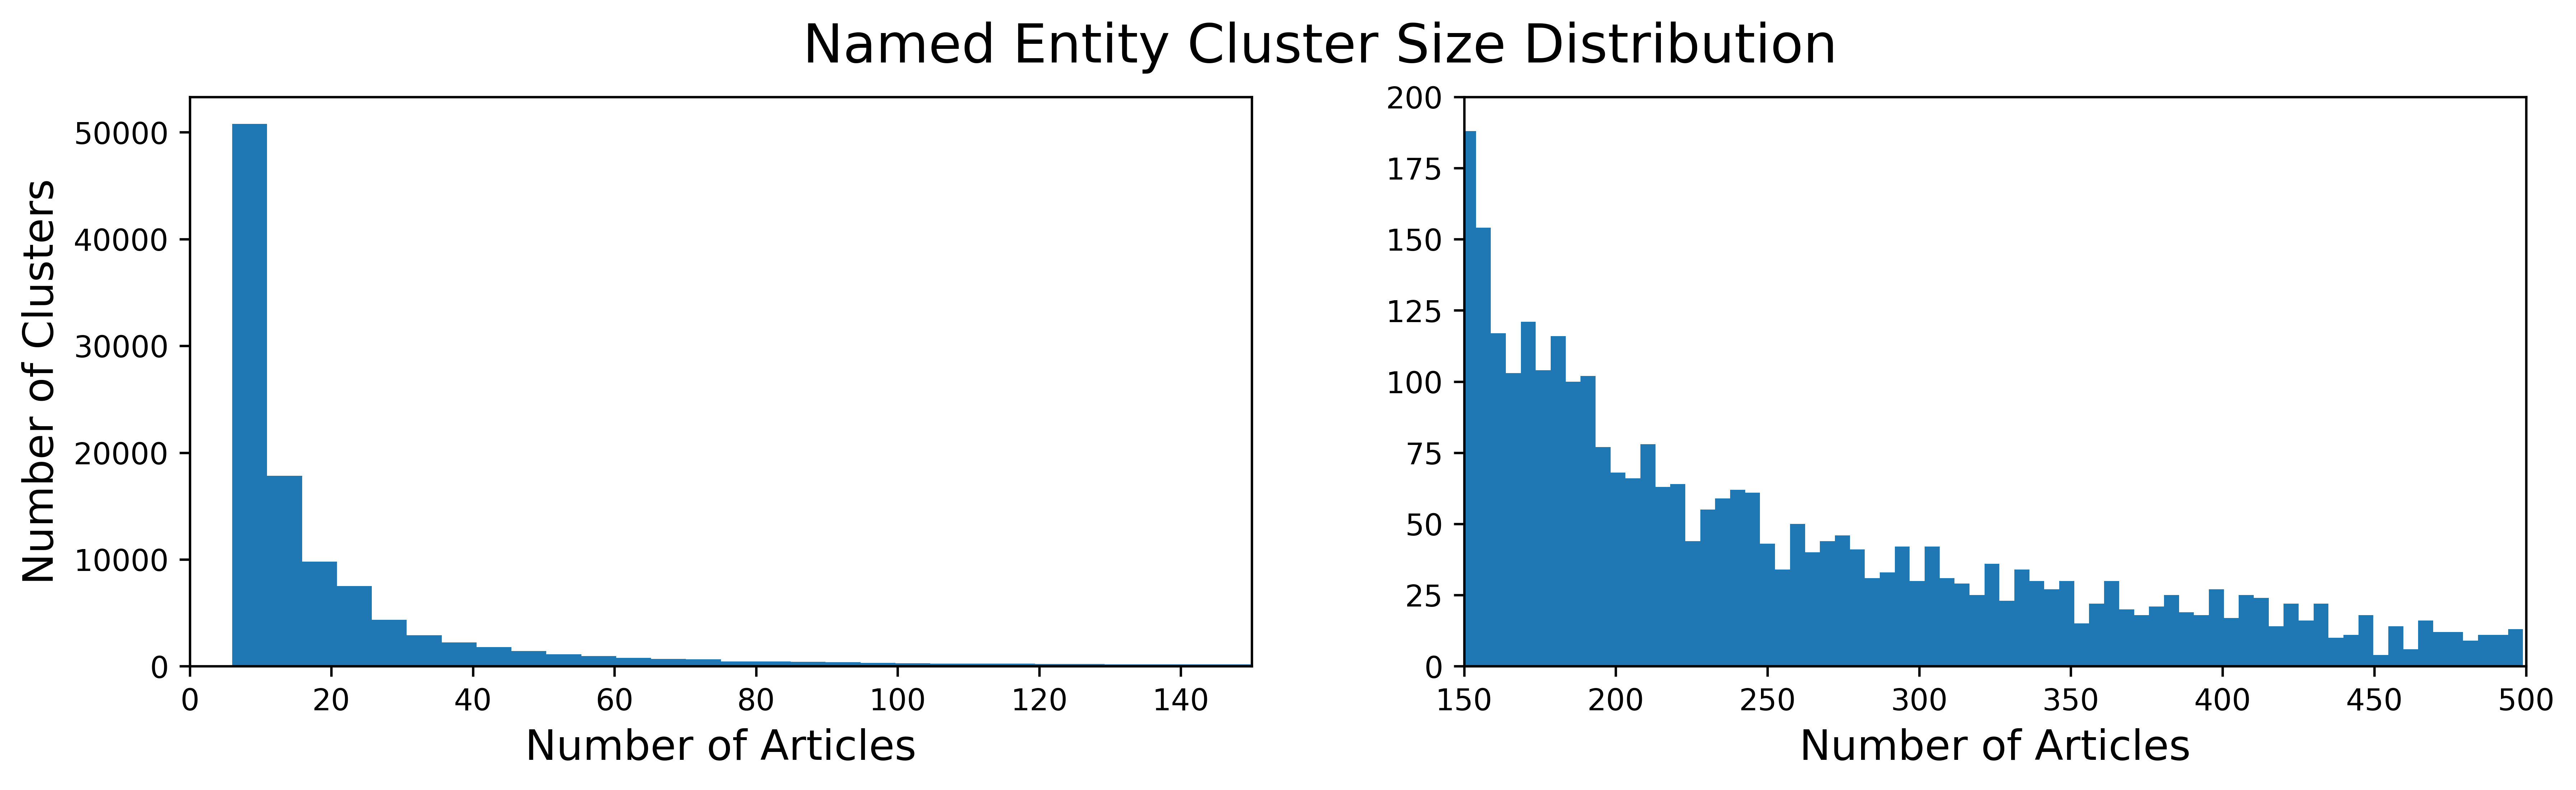

In [96]:
plt.clf()
plt.rcParams['figure.dpi'] = 600
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14, 3.5])

axs[0].hist(groupedLean["numArticles"], bins=100)
axs[0].set_xlim([0, 150])
axs[0].set_xlabel("Number of Articles", size=14)
axs[0].set_ylabel("Number of Clusters", size=14)

axs[1].hist(groupedLean["numArticles"], bins=100)
axs[1].set_xlim([150, 500])
axs[1].set_ylim([0, 200])
axs[1].set_xlabel("Number of Articles", size=14)
fig.suptitle("Named Entity Cluster Size Distribution", size=18)


In [97]:
#now that we have clusters, we want to get embeddings 
#first, we need to unravel the clusters so that we have pairwise rows

In [99]:
def getPairwise(inList): 
    outList = []
    inLen = len(inList)
    for i in range(0, inLen):
        for j in range(i+1, inLen): 
            outList.append([inList[i], inList[j]])
    return outList
    
def getPairwiseSim(inList):
    outList = []
    inLen = len(inList)
    for i in range(0, inLen):
        for j in range(i+1, inLen):
            sim = 1-distance.cosine(inList[i], inList[j])
            outList.append(sim)
            
    return outList

# NOTE: this step uses lots of memory 
# 1% when using 300,000 rows of original data 

In [100]:
#def getPairwise(inList): 
#    return [(item1, item2) for item2 in inList for item1 in inList]

#we only needed the articleNum column for filtering 
testDf = groupedLean[["key", "embedding"]]

#get all of the pairs for a given list of articles and a given list of embeddings 
testDf["embedding"] = testDf["embedding"].apply(getPairwise)
testDf["key"] = testDf["key"].apply(getPairwise)

<ipython-input-100-020cde786738>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["embedding"] = testDf["embedding"].apply(getPairwise)
<ipython-input-100-020cde786738>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testDf["key"] = testDf["key"].apply(getPairwise)


In [28]:
testDf

key  \
ent_type entity                                                                        
event    148th fighter wing        [[100296, 100325], [100296, 100334], [100296, ...   
         155th juneteenth          [[204199, 205906], [204199, 207646], [204199, ...   
         1917                      [[56615, 56616], [56615, 81693], [56615, 87050...   
         3m championship           [[275310, 275337], [275310, 275376], [275310, ...   
         50th wedding anniversary  [[21008, 40416], [21008, 110099], [21008, 1664...   
...                                                                              ...   
product  zoom                      [[1404, 1417], [1404, 1417], [1404, 1646], [14...   
         zoot                      [[154615, 156931], [154615, 157262], [154615, ...   
         zpak                      [[3092, 3092], [3092, 3125], [3092, 3125], [30...   
         zumba                     [[646, 11358], [646, 11840], [646, 12655], [64...   
         zumper                    [[17090, 99467], [17090, 128816], [17090, 2582...   

                                                                           embedding  
ent_type entity                                                                       
event    148th fighter wing        [[[-0.08305705338716507, 0.04867418110370636, ...  
         155th juneteenth          [[[-0.013154401443898678, 0.38175368309020996,...  
         1917                      [[[0.05219216272234917, -0.02841889299452305, ...  
         3m championship           [[[-0.09098821878433228, -0.0961516872048378, ...  
         50th wedding anniversary  [[[-0.001636103494092822, -0.07590212672948837...  
...                                                                              ...  
product  zoom                      [[[-0.13343222439289093, -0.07854493707418442,...  
         zoot                      [[[0.1192050501704216, 0.15432637929916382, 0....  
         zpak                      [[[-0.07429765909910202, 0.17444054782390594, ...  
         zumba                     [[[-0.04068465903401375, 0.1636635661125183, 0...  
         zumper                    [[[-0.14034788310527802, -0.07091709226369858,...  

[110076 rows x 2 columns]

In [87]:
#give each 
leanTest = testDf[:3000].apply(pd.Series.explode)
leanTest.shape

ValueError: cannot handle a non-unique multi-index!

In [47]:
leanTest[["key1", "key2"]] =  leanTest["key"].to_list()
leanTest = leanTest.drop(columns=["key"]).reset_index()

In [76]:
def first(inList): 
    if len(inList) > 0: 
        return inList[0]
    else: 
        return inList

groupedTest = leanTest.groupby(by=["key1", "key2"]).agg({"ent_type":list, "entity":list, "embedding":lambda x: x.iloc[0]})

In [78]:
groupedTest["numClusts"] = groupedTest["entity"].apply(len)

(array([5.9447e+04, 1.2230e+03, 5.6400e+02, 4.7000e+01, 3.1000e+02,
        0.0000e+00, 1.4630e+03, 7.0000e+00, 0.0000e+00, 6.6000e+01,
        4.3000e+01, 0.0000e+00, 1.3000e+01, 0.0000e+00, 5.8000e+01,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        0.0000e+00, 2.0000e+00, 2.8000e+01, 1.0000e+00, 4.0000e+00,
        4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.6000e+01, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.9000e+01, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        5.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.8000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 3.7800e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

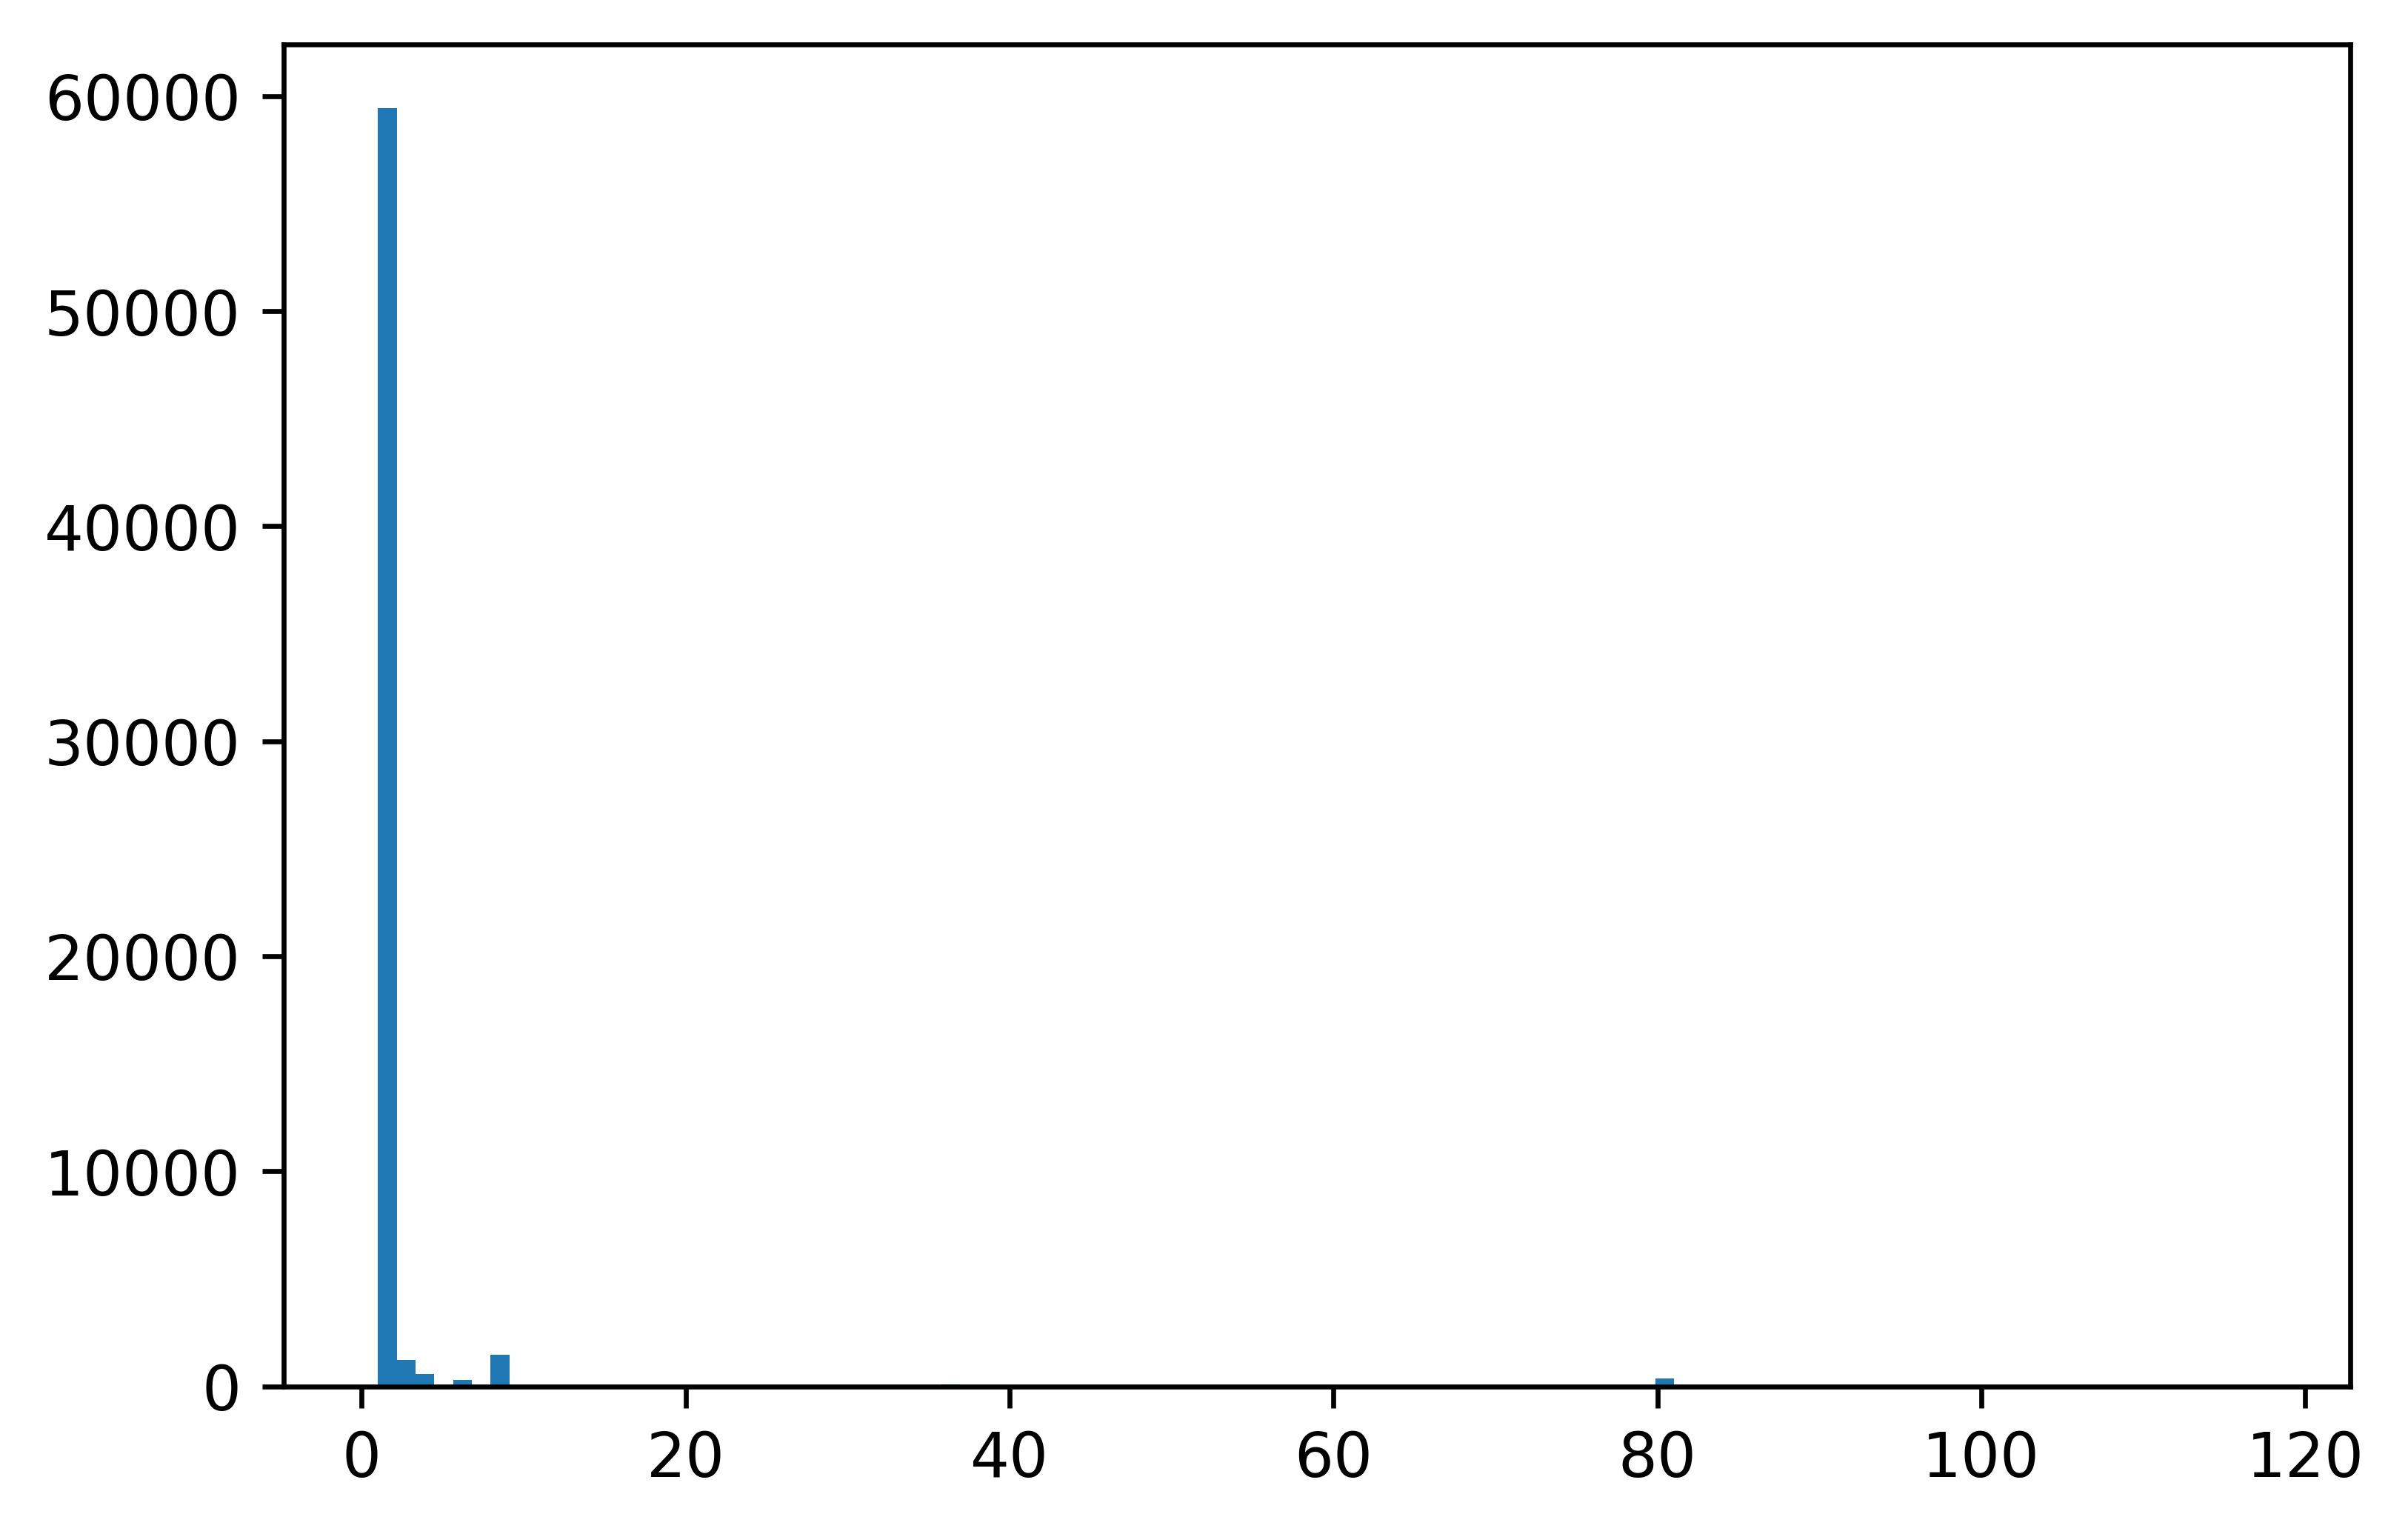

In [81]:
plt.hist(grouped["numClusts"], bins=100)

In [85]:
from tqdm.notebook import tqdm 
from multiprocessing import Pool 

def getCos(inList): 
    return 1 - distance.cosine(inList[0], inList[1])

def getCosSeries(inSeries): 
    return inSeries.apply(getCos)

#tqdm.pandas()
#exploded.head(1000000)["embedding"].progress_map(getCos)

testDf = grouped
testEmbeddings = testDf["embedding"]

with Pool(12) as pool: 
    splitList = np.array_split(testEmbeddings, 10)
    similarityArrs = list(tqdm(pool.imap(getCosSeries, splitList), total=10))
    similarity = pd.concat(similarityArrs)

testDf["similarity"] = similarity


  0%|          | 0/10 [00:00<?, ?it/s]

In [86]:
testDf

ent_type                      entity  \
key1   key2                                          
205    235     [event]             [academy award]   
       334     [event]             [academy award]   
       3712    [event]             [academy award]   
       4232    [event]             [academy award]   
       19614   [event]             [academy award]   
...                ...                         ...   
298741 299852  [event]  [black lives matter plaza]   
299146 299176  [event]            [a world series]   
       299259  [event]            [a world series]   
299176 299259  [event]            [a world series]   
299786 299786  [event]              [a super bowl]   

                                                       embedding  numClusts  \
key1   key2                                                                   
205    235     [[0.007725594099611044, -0.13795332610607147, ...          1   
       334     [[0.007725594099611044, -0.13795332610607147, ...          1   
       3712    [[0.007725594099611044, -0.13795332610607147, ...          1   
       4232    [[0.007725594099611044, -0.13795332610607147, ...          1   
       19614   [[0.007725594099611044, -0.13795332610607147, ...          1   
...                                                          ...        ...   
298741 299852  [[-0.02035110630095005, 0.14541108906269073, 0...          1   
299146 299176  [[-0.0718747153878212, 0.11510315537452698, -0...          1   
       299259  [[-0.0718747153878212, 0.11510315537452698, -0...          1   
299176 299259  [[-0.06662287563085556, 0.09298715740442276, -...          1   
299786 299786  [[-0.0376642569899559, 0.0656069666147232, -0....          1   

               similarity  
key1   key2                
205    235       0.958361  
       334       0.966169  
       3712      0.820569  
       4232      0.800786  
       19614     0.020788  
...                   ...  
298741 299852    0.840591  
299146 299176    0.969996  
       299259    0.976439  
299176 299259    0.975204  
299786 299786    1.000000  

[63915 rows x 5 columns]